# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Описание данных

### Технологический процесс

    Rougher feed — исходное сырье
    Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
        Xanthate **— ксантогенат (промотер, или активатор флотации);
        Sulphate — сульфат (на данном производстве сульфид натрия);
        Depressant — депрессант (силикат натрия).
    Rougher process (англ. «грубый процесс») — флотация
    Rougher tails — отвальные хвосты
    Float banks — флотационная установка
    Cleaner process — очистка
    Rougher Au — черновой концентрат золота
    Final Au — финальный концентрат золота

### Параметры этапов

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи

## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Модели

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, KFold


from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, make_scorer


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault
from sklearn.model_selection import GridSearchCV
import numpy as np
import itertools 
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from functools import reduce   
from scipy import stats as st

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model
from feature_engine.selection import DropCorrelatedFeatures, DropDuplicateFeatures

from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from imblearn.pipeline import make_pipeline
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor

## Подготовка данных

In [2]:
try:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

In [3]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [8]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [9]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [10]:
data_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


In [11]:
data_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


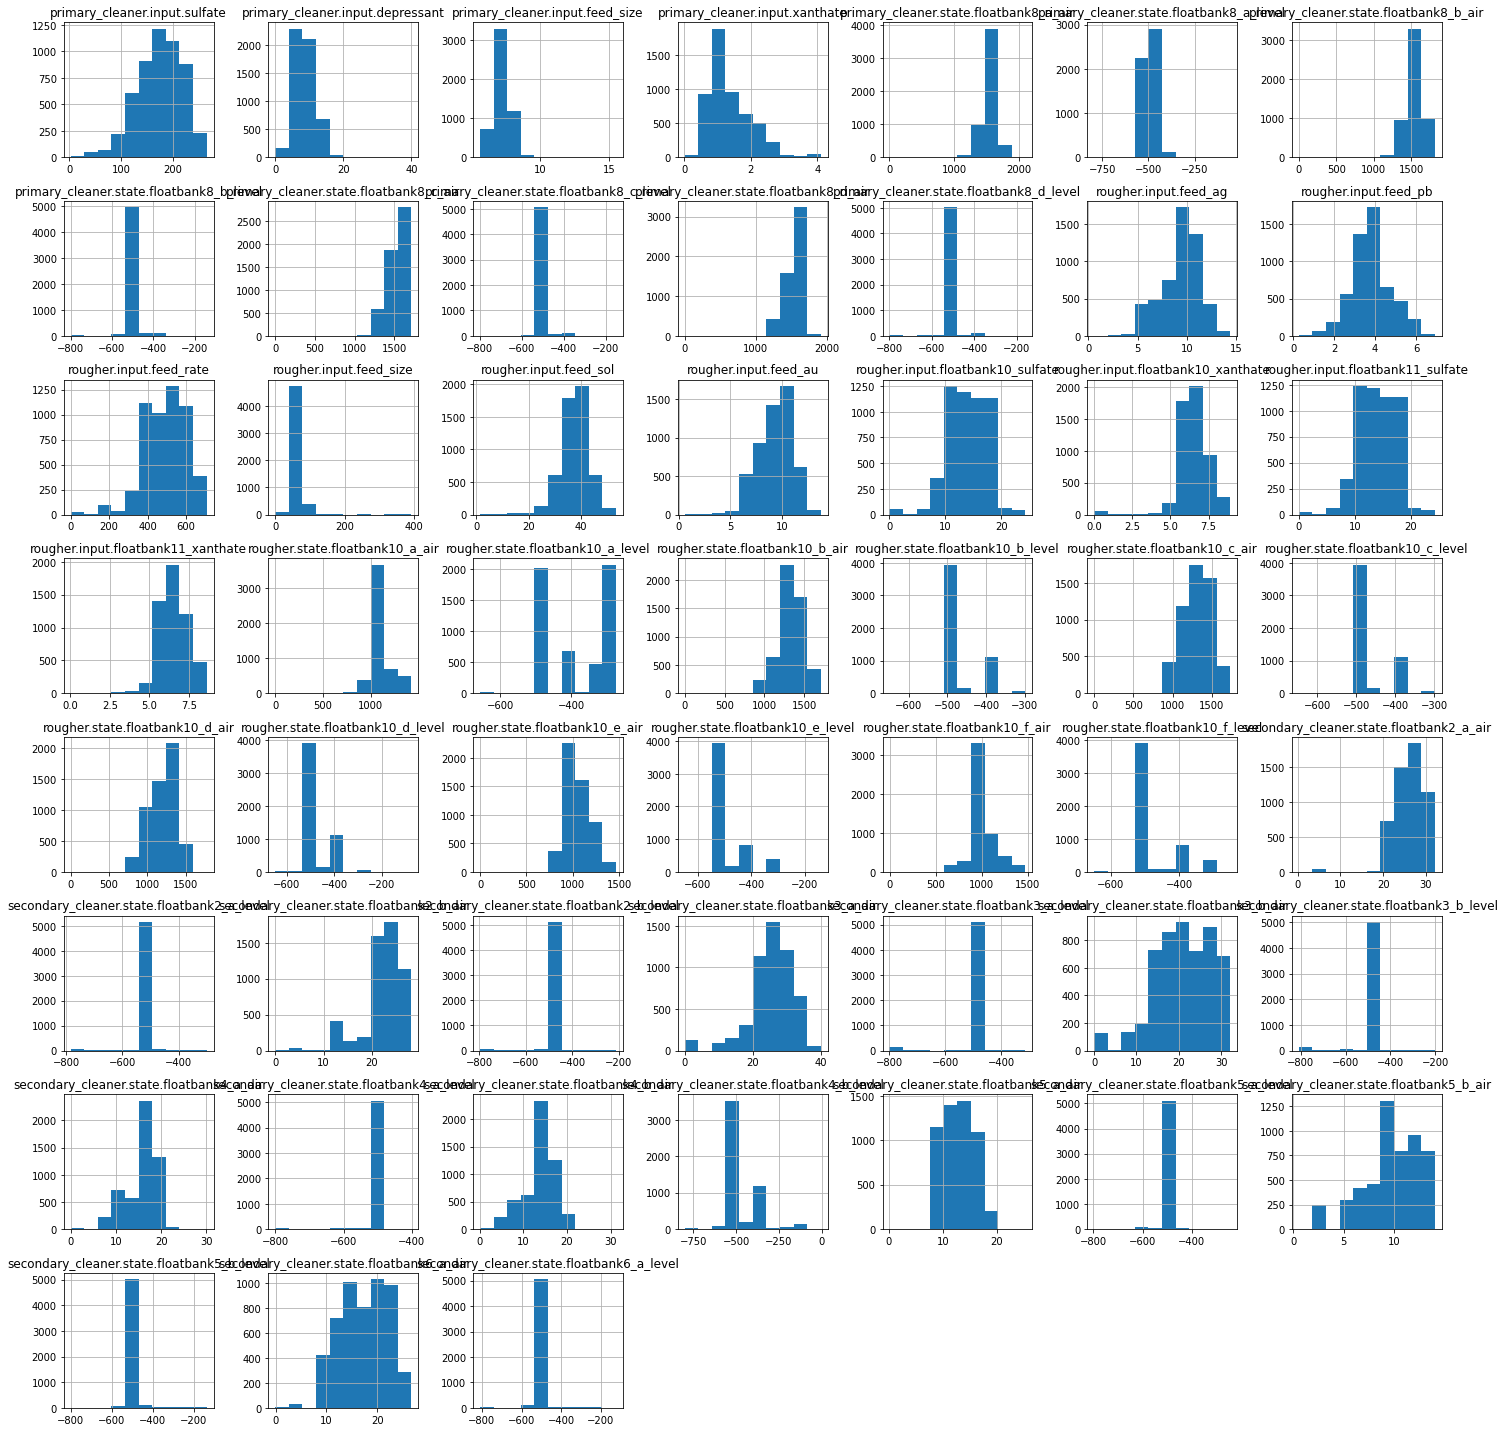

In [12]:
data_test.hist(figsize=(20, 20))
plt.tight_layout() 

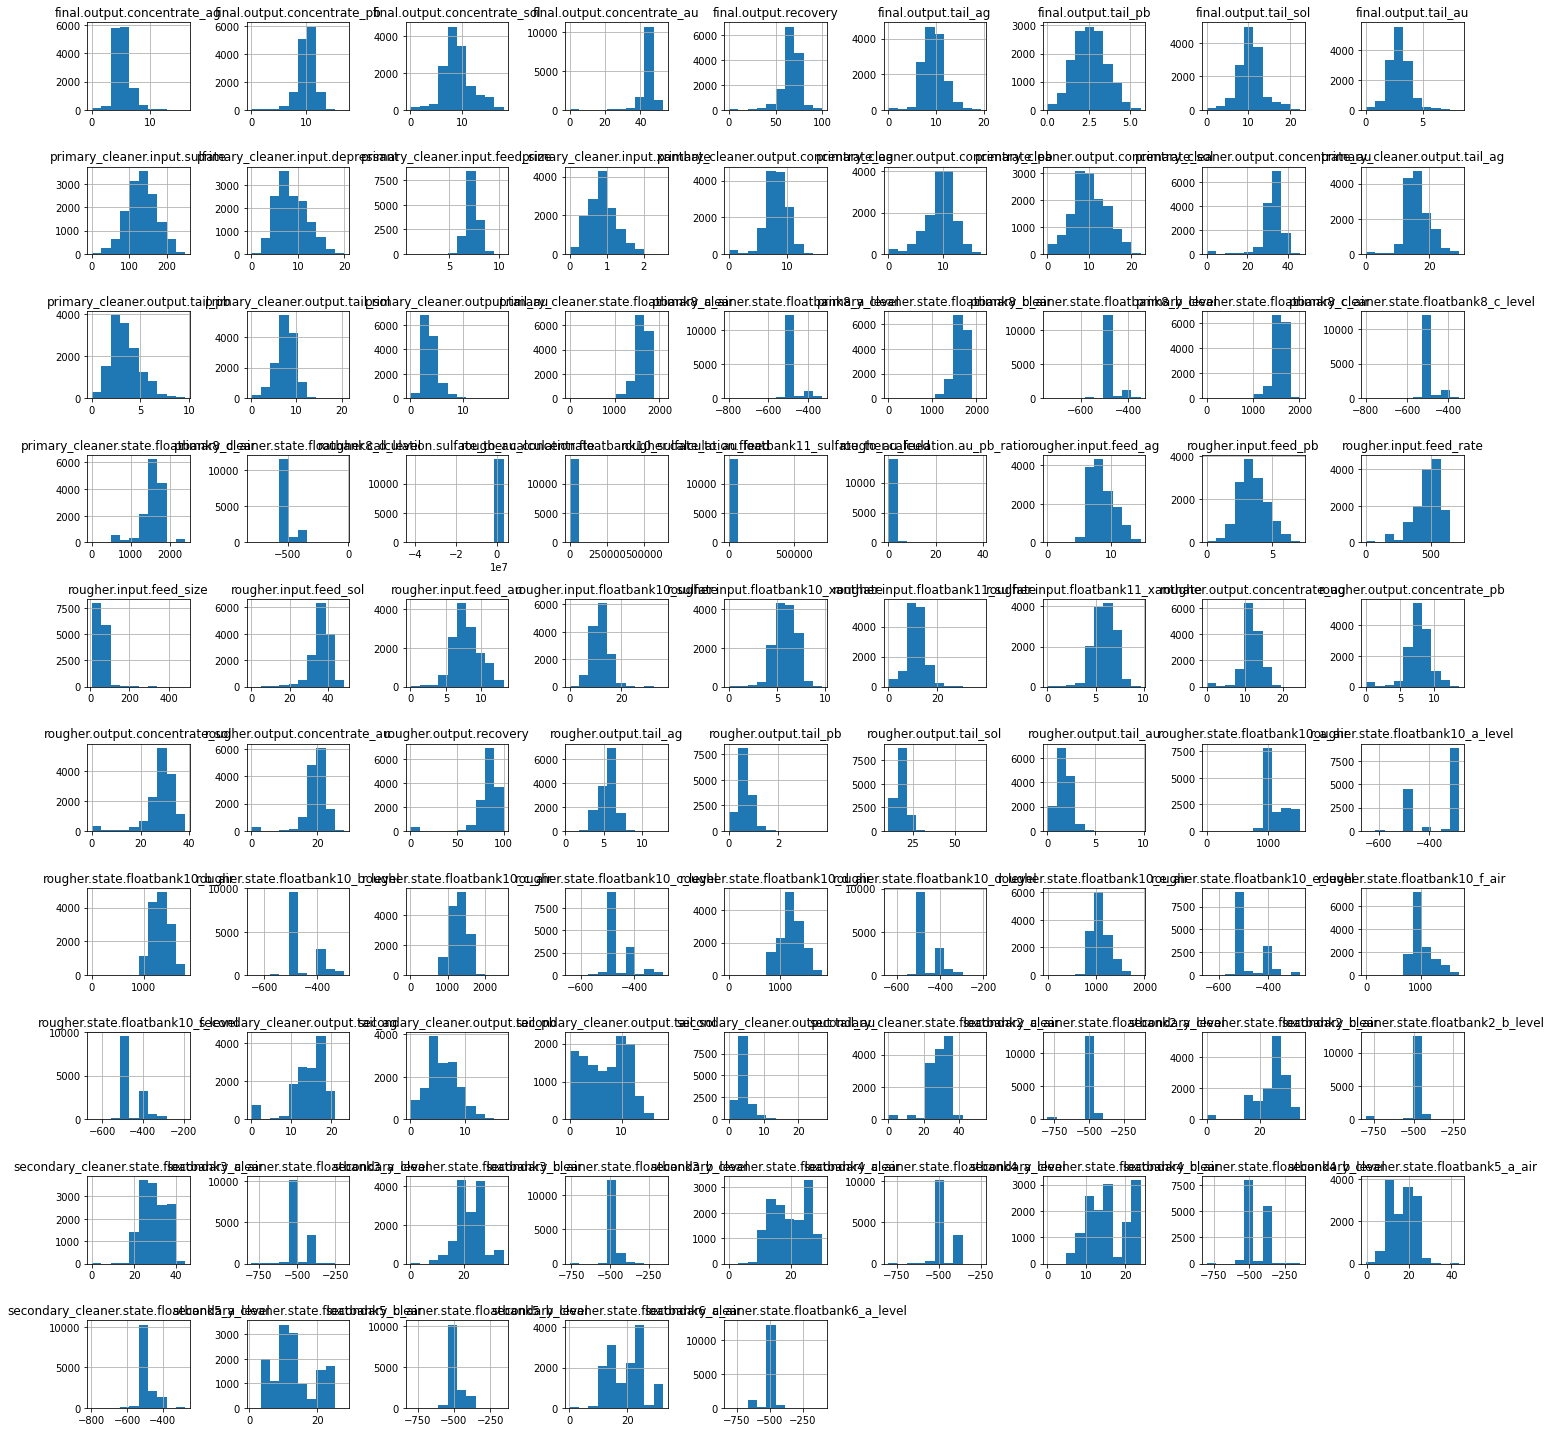

In [13]:
data_train.hist(figsize=(20, 20))
plt.tight_layout() 

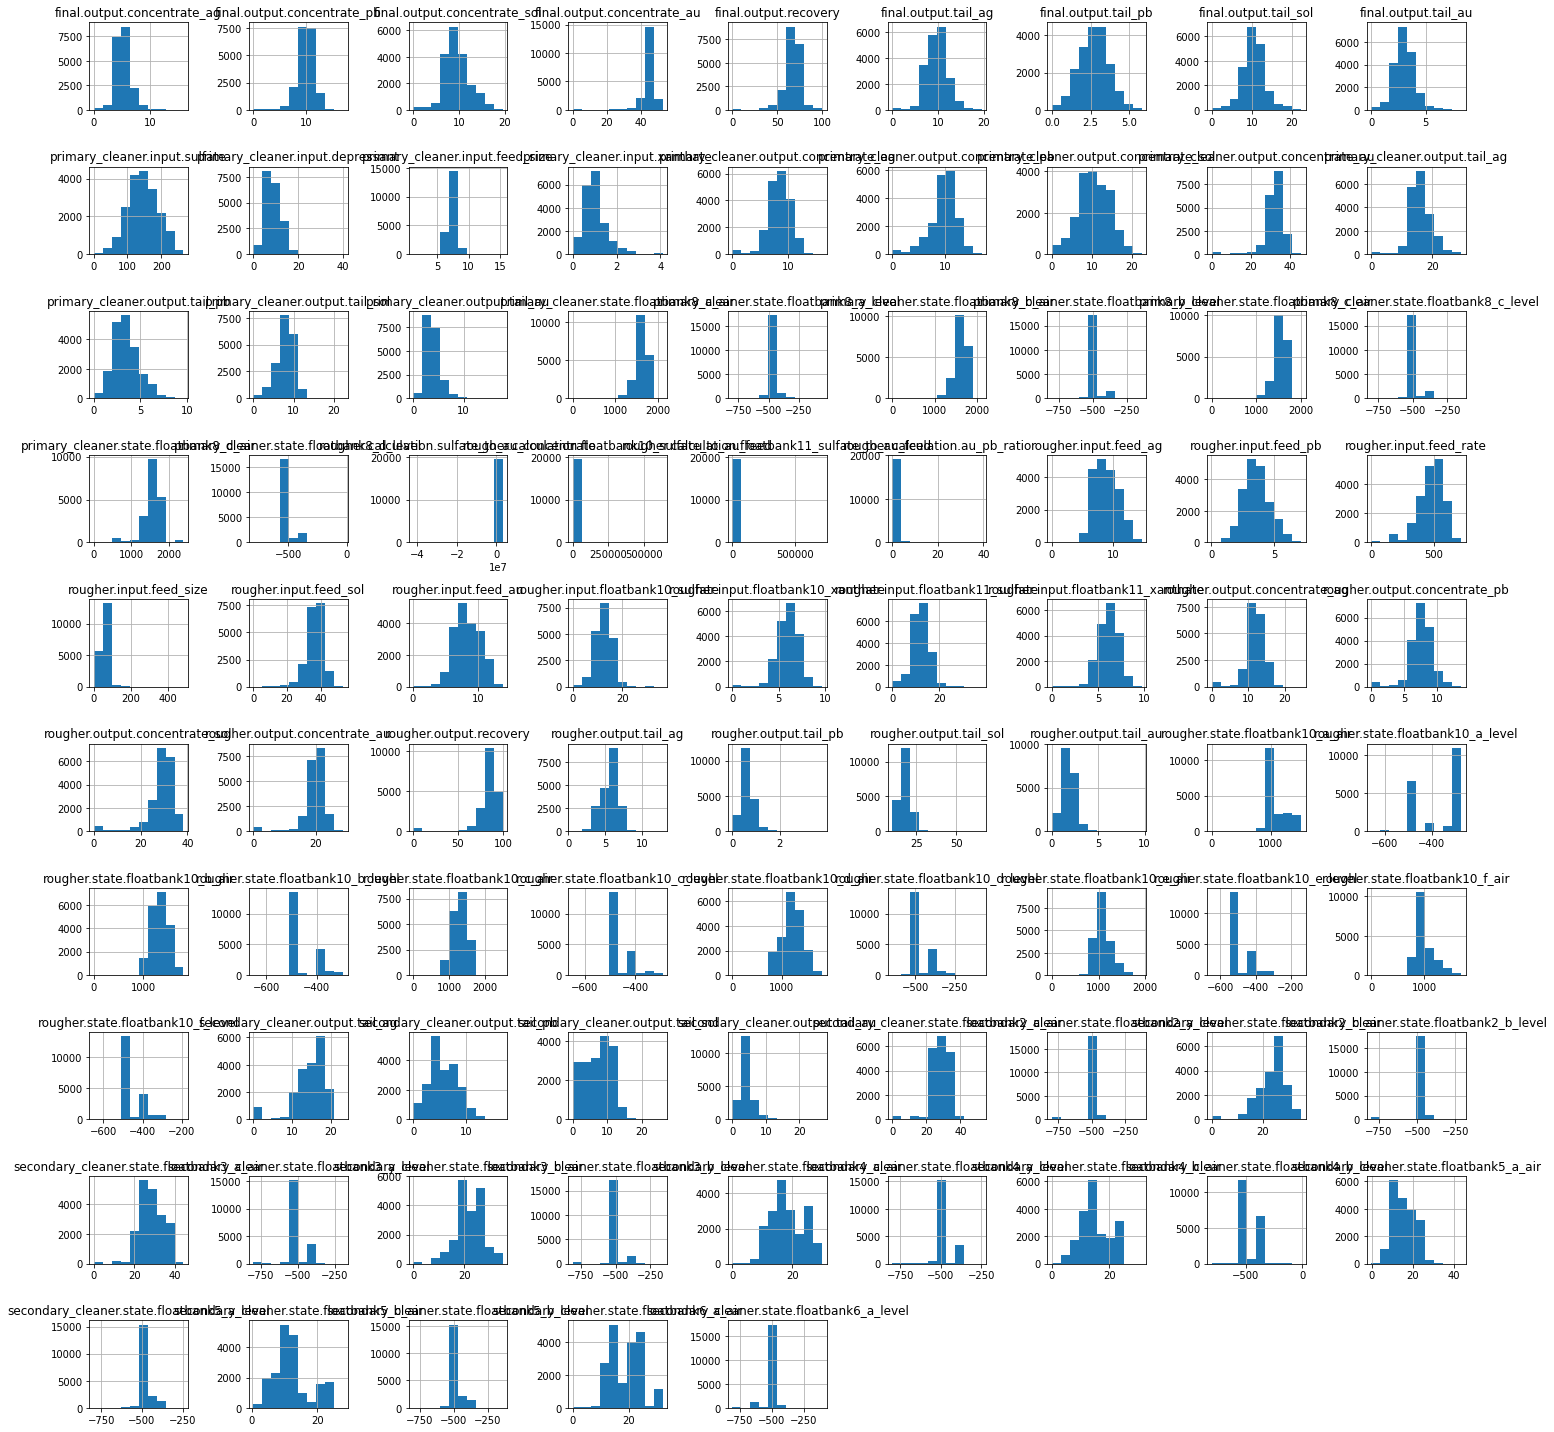

In [14]:
data_full.hist(figsize=(20, 20))
plt.tight_layout() 

## Проверка правильности расчета эффективности обогащения

### Напишем функцию recovery

In [15]:


def recovery(c,f,t):

    prerecovery = (c*(f-t)) / (f*(c-t))
    recovery = prerecovery * 100
    return recovery



     


In [16]:

c = data_train['rougher.output.concentrate_au']
f = data_train['rougher.input.feed_au']
t = data_train['rougher.output.tail_au']

recovery(c,f,t)


0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

In [17]:
recovery_check = recovery(c,f,t)

### Посчитаем MAE

In [18]:
mean_absolute_error(data_train['rougher.output.recovery'].fillna(0),recovery_check.fillna(0))

9.73512347450521e-15

**Выводы**

Значение MAE низкое - расчет эффективности обогащения относительно правильный.

## Проанализируем параметры недоступные в тестовой выборке

In [19]:
data_full.columns.difference(data_train.columns)

Index([], dtype='object')

In [20]:
difference_table = pd.pivot_table(data_full, index=['date'], values=data_full.columns.difference(data_test.columns))
difference_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_au                         19439 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_au                                19439 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                            

In [21]:
len(list(data_full.columns.difference(data_test.columns)))

34

**Вывод**

34 численных признака отсутствуют в тестовой выборке.

## Предобработка данных

### Удалим признаки в обучающей выборке отсутствующие в тестовой

In [22]:
data_train = data_train[data_test.columns]

In [23]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   primary_cleaner.input.sulfate               14129 non-null  float64
 2   primary_cleaner.input.depressant            14117 non-null  float64
 3   primary_cleaner.input.feed_size             14149 non-null  float64
 4   primary_cleaner.input.xanthate              14049 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      14147 non-null  float64
 10  primary_cl

In [24]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

### Удалим пустые строки

In [25]:
data_train.dropna(inplace=True)

In [26]:
data_train.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [27]:
data_test.dropna(inplace=True)

In [28]:

data_train.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

**Выводы**
- Были удалены лишние признаки и пропуски
- Остальные этапы обработки попробую сделать через pipeline

## Анализ данных

In [29]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12679 entries, 0 to 14148
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        12679 non-null  object 
 1   primary_cleaner.input.sulfate               12679 non-null  float64
 2   primary_cleaner.input.depressant            12679 non-null  float64
 3   primary_cleaner.input.feed_size             12679 non-null  float64
 4   primary_cleaner.input.xanthate              12679 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      12679 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    12679 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      12679 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    12679 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      12679 non-null  float64
 10  primary_cl

### Посмотрим, как меняется концентрация металлов  на различных этапах очистки.

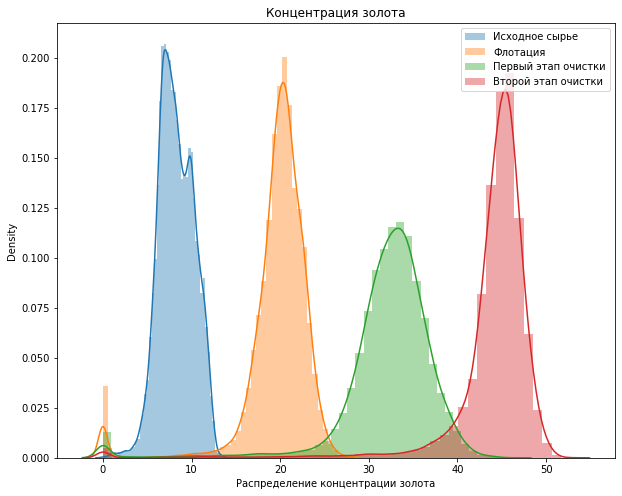

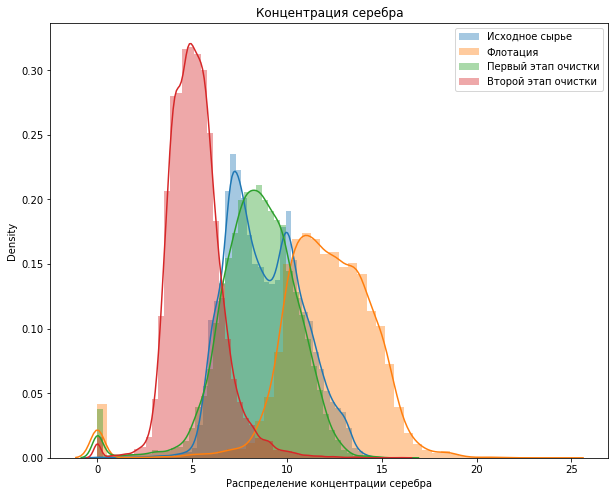

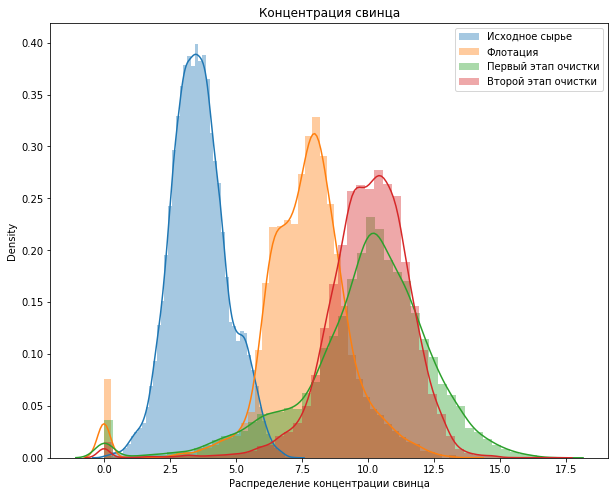

In [30]:
metals = [('au', 'золота'), ('ag', 'серебра'), ('pb', 'свинца')]

stages = [     ('rougher.input.feed_', 'Исходное сырье '), 
               ('rougher.output.concentrate_', 'Флотация'), 
               ('primary_cleaner.output.concentrate_', 'Первый этап очистки'), 
               ('final.output.concentrate_', 'Второй этап очистки')]


for i in metals:
    plt.figure(figsize=(10,8))
    for item in stages:
        ax = sns.distplot(data_full[item[0] + i[0]], label=item[1])
        plt.legend()
        _ = ax.set(xlabel='Распределение концeнтрации ' + i[1], 
                   title='Концентрация ' + i[1])
    plt.show()

**Выводы**
Концентрация золота возрастает на всех этапах

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

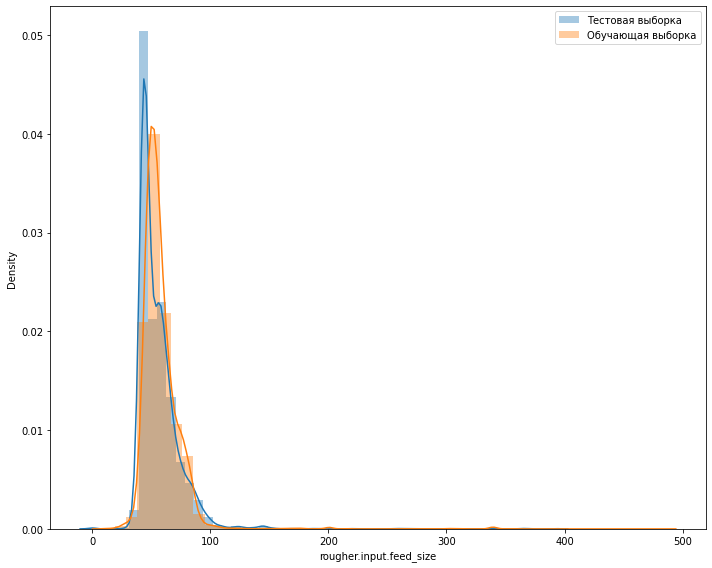

In [31]:
plt.figure(figsize=(10,8))
sns.distplot(data_test['rougher.input.feed_size'], label='Тестовая выборка')
sns.distplot(data_train['rougher.input.feed_size'], label='Обучающая выборка')
plt.legend()
plt.tight_layout() 


**Вывод**

Распределения отличаются не слишком сильно. Оценка будет правильной.

### Исследуем суммарную концентрацию всех веществ на разных стадиях

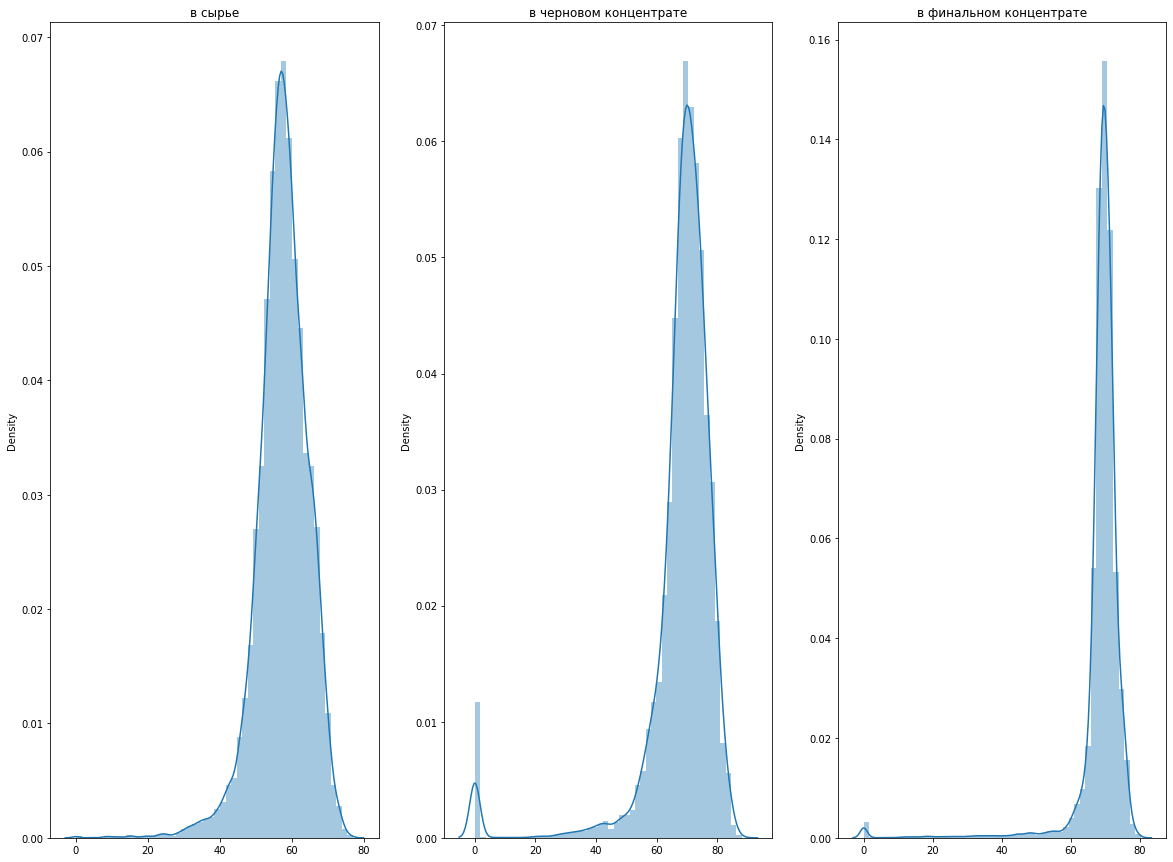

In [32]:
concentration_stages = [('rougher.input.feed_', 'в сырье'),
                        ('rougher.output.concentrate_', 'в черновом концентрате'), 
                        ('final.output.concentrate_', 'в финальном концентрате')]


fig, axs = plt.subplots(1, len(concentration_stages), figsize=(20, 15))


for stage, ax in zip(concentration_stages, axs):
    ax.set_title(stage[1])
    data_full_sum =  data_full[stage[0]+ 'ag'] + data_full[stage[0]+ 'au'] + data_full[stage[0]+ 'pb'] + data_full[stage[0]+ 'sol']

    sns.distplot(data_full_sum, ax=ax)   

plt.show()

**Выводы** Следует удалить аномалии возле нулевой отметки

### Удалим аномалии

In [33]:
data_train = data_train.replace(0, np.nan)
data_train = data_train.dropna(how='all', axis=0)

In [34]:
data_train.dropna(inplace=True)

In [35]:
#data_train = data_train.set_index('date')
#data_full = data_full.set_index('date')
#data_train = data_train.loc[data_train.index.isin(data_full.index)]


In [36]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12662 entries, 0 to 14148
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        12662 non-null  object 
 1   primary_cleaner.input.sulfate               12662 non-null  float64
 2   primary_cleaner.input.depressant            12662 non-null  float64
 3   primary_cleaner.input.feed_size             12662 non-null  float64
 4   primary_cleaner.input.xanthate              12662 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      12662 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    12662 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      12662 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    12662 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      12662 non-null  float64
 10  primary_cl

### Графики без аномалий

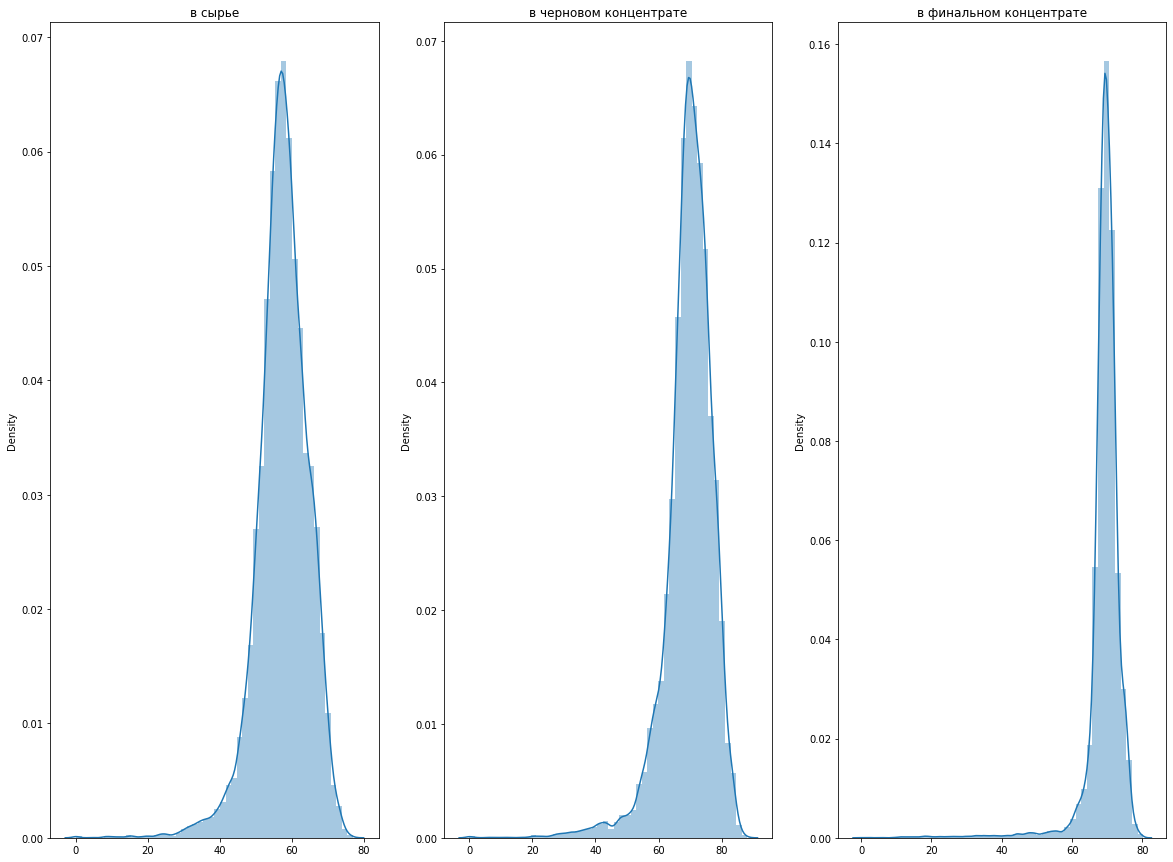

In [37]:
fig, axs = plt.subplots(1, len(concentration_stages), figsize=(20, 15))


for stage, ax in zip(concentration_stages, axs):
    ax.set_title(stage[1])
    correct =  data_full[stage[0]+ 'ag'] + data_full[stage[0]+ 'au'] + data_full[stage[0]+ 'pb'] + data_full[stage[0]+ 'sol']
    sns.distplot(correct.replace(0,np.nan).dropna(), ax=ax) 

plt.show()

**Выводы**

На финальной стадии концетрация уменьшается.

## Построим модель 

### Удалим столбец date

In [38]:
data_test.drop(['date'], axis=1, inplace=True)
data_train.drop(['date'], axis=1, inplace=True)

In [39]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5289
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5229 non-null   float64
 1   primary_cleaner.input.depressant            5229 non-null   float64
 2   primary_cleaner.input.feed_size             5229 non-null   float64
 3   primary_cleaner.input.xanthate              5229 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5229 non-null   float64
 10  primary_clea

In [40]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12662 entries, 0 to 14148
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               12662 non-null  float64
 1   primary_cleaner.input.depressant            12662 non-null  float64
 2   primary_cleaner.input.feed_size             12662 non-null  float64
 3   primary_cleaner.input.xanthate              12662 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      12662 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    12662 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      12662 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    12662 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      12662 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    12662 non-null  float64
 10  primary_cl

### Создадим выборки

In [41]:

X_train_rougher = data_train
X_test_rougher = data_test
y_train_rougher = data_full.loc[X_train_rougher.index, 'rougher.output.recovery']
y_test_rougher = data_full.loc[X_test_rougher.index,'final.output.recovery']

X_train_final = data_train
X_test_final = data_test
y_train_final = data_full.loc[X_train_final.index, 'final.output.recovery']
y_test_final = data_full.loc[X_test_final.index, 'final.output.recovery']


### Заполним пропуски средними

In [42]:
y_train_final = y_train_final.fillna(y_train_final.mean())
y_train_rougher = y_train_rougher.fillna(y_train_rougher.mean())

### Проверим выборки на размер

In [43]:
X_train_rougher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12662 entries, 0 to 14148
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               12662 non-null  float64
 1   primary_cleaner.input.depressant            12662 non-null  float64
 2   primary_cleaner.input.feed_size             12662 non-null  float64
 3   primary_cleaner.input.xanthate              12662 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      12662 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    12662 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      12662 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    12662 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      12662 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    12662 non-null  float64
 10  primary_cl

In [44]:
X_test_rougher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5289
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5229 non-null   float64
 1   primary_cleaner.input.depressant            5229 non-null   float64
 2   primary_cleaner.input.feed_size             5229 non-null   float64
 3   primary_cleaner.input.xanthate              5229 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5229 non-null   float64
 10  primary_clea

In [45]:
#y_train_rougher.info()

In [46]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12662 entries, 0 to 14148
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               12662 non-null  float64
 1   primary_cleaner.input.depressant            12662 non-null  float64
 2   primary_cleaner.input.feed_size             12662 non-null  float64
 3   primary_cleaner.input.xanthate              12662 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      12662 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    12662 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      12662 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    12662 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      12662 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    12662 non-null  float64
 10  primary_cl

In [47]:
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5289
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5229 non-null   float64
 1   primary_cleaner.input.depressant            5229 non-null   float64
 2   primary_cleaner.input.feed_size             5229 non-null   float64
 3   primary_cleaner.input.xanthate              5229 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5229 non-null   float64
 10  primary_clea

In [48]:
#y_train_final.info()

In [49]:
#y_test_final.info()

### Напишем функцию итоговой sMAPE

In [50]:
def smape(target, preds):
    smape =  ((1/len(target)) * np.sum(2 * np.abs(target - preds) / (np.abs(target) + np.abs(preds)))) * 100 
    return smape

In [51]:
def final_smape(smape_rougher, smape_final):
    final_smape = 0.25*smape_rougher + 0.75*smape_final
    return final_smape
    

### Передадим функцию в make_scorer

In [52]:
smape_score = make_scorer(smape, greater_is_better=False)

### Построим Pipeline

In [53]:
state = RandomState(42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan)),
    ('scaler', MinMaxScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=state))
])

params = [
    {
        'imputer__strategy': ['mean', 'median'],
        'model': [RandomForestRegressor(n_estimators=10, random_state=state)],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, {
        'imputer__strategy': ['mean', 'median'],
        'model': [LinearRegression()]
    }, {
        'imputer__strategy': ['mean', 'median'],
        'model': [RandomForestRegressor(random_state=state)],
        'model__n_estimators': [2,10,50],
        'model__max_depth': [3,5,15],
        'model__max_features': [None, 'sqrt', 5,]

        
    },
    {
        'imputer__strategy': ['mean', 'median'],
        'model': [linear_model.Lasso(random_state=state)],
        'model__alpha': np.logspace(-3, 1, 10)
    }
]


### Проведем кросс валидацию и обучим модель на выборке rougher


In [54]:
cv = KFold(n_splits=5, shuffle=False)
grid_rougher = GridSearchCV(pipeline, param_grid=params, cv=cv, n_jobs=-1, scoring=smape_score)


In [55]:
grid_rougher.fit(X_train_rougher, y_train_rougher)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=RandomState(MT19937) at 0x7FAB75877140))]),
             n_jobs=-1,
             param_grid=[{'imputer__strategy': ['mean', 'median'],
                          'model': [RandomForestRegressor(n_estimators=10,
                                                          random_stat...
                         {'imputer__strategy': ['mean', 'median'],
                          'model': [Lasso(alpha=0.1668100537200059,
                                          random_state=RandomState(MT19937) at 0x7FAB75877140)],
                          'model__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])}],
             scoring=make_scorer(smape, greater_is_better=False))

In [56]:
 grid_rougher.best_params_

{'imputer__strategy': 'mean',
 'model': Lasso(alpha=0.1668100537200059,
       random_state=RandomState(MT19937) at 0x7FAB75877140),
 'model__alpha': 0.1668100537200059}

In [57]:
-grid_rougher.best_score_

9.818315196932623

### Проведем кросс валидацию и обучим модель на выборке final

In [58]:
grid_final = GridSearchCV(pipeline, param_grid=params, cv=cv, n_jobs=-1,scoring=smape_score)

In [59]:
grid_final.fit(X_train_final, y_train_final)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=RandomState(MT19937) at 0x7FAB75877140))]),
             n_jobs=-1,
             param_grid=[{'imputer__strategy': ['mean', 'median'],
                          'model': [RandomForestRegressor(n_estimators=10,
                                                          random_stat...
                         {'imputer__strategy': ['mean', 'median'],
                          'model': [Lasso(alpha=0.1668100537200059,
                                          random_state=RandomState(MT19937) at 0x7FAB75877140)],
                          'model__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])}],
             scoring=make_scorer(smape, greater_is_better=False))

In [60]:
grid_final.best_params_

{'imputer__strategy': 'mean',
 'model': RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=10,
                       random_state=RandomState(MT19937) at 0x7FAB75877140),
 'model__max_depth': 3,
 'model__max_features': 'sqrt',
 'model__n_estimators': 10}

In [61]:
-grid_final.best_score_

10.043597684957374

### Лучшая модель для тестовой выборки rougher

In [62]:
pipe_rougher = grid_rougher.best_estimator_

pipe_rougher.fit(X_train_rougher, y_train_rougher)
y_pred = pipe_rougher.predict(X_test_rougher)

smape_rougher = smape(data_full.loc[X_test_rougher.index, 'rougher.output.recovery'], y_pred)


In [63]:
smape_rougher

11.316863814196903

### Лучшая модель для тестовой выборки final

In [64]:
pipe_final = grid_final.best_estimator_
    
pipe_final.fit(X_train_final, y_train_final)
y_pred_final = pipe_final.predict(X_test_final)

smape_final = smape(data_full.loc[X_test_rougher.index, 'final.output.recovery'],y_pred_final)



In [65]:
smape_final

10.636309112839648

### Расчитаем Итоговый Smape

In [66]:
final_smape(smape_rougher, smape_final)

10.80644778817896

In [67]:
### Расчитаем smape для rougher

smape_rougher = smape(data_full.loc[X_test_rougher.index, 'rougher.output.recovery'], y_pred)
smape_rougher

11.316863814196903

In [68]:
### Расчитаем smape для final
smape_final = smape(data_full.loc[X_test_rougher.index, 'final.output.recovery'],y_pred_final)
smape_final

10.636309112839648

In [69]:
## Итоговый smape
final_smape(smape_rougher, smape_final)

10.80644778817896

### Проверка адекватности модели на rougher

In [70]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_rougher, y_train_rougher)
predicted_dummy = dummy_reg.predict(X_test_rougher)

dummy_rougher = smape(data_full.loc[X_test_rougher.index, 'rougher.output.recovery'], predicted_dummy)
dummy_rougher

11.485852975512936

### Проверка адекватности модели на final

In [71]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_final, y_train_final)
predicted_dummy_final = dummy_reg.predict(X_test_final)

dummy_final = smape(data_full.loc[X_test_final.index, 'final.output.recovery'], predicted_dummy_final)
dummy_final

10.602994330450242

### Итоговый smape для dummy

In [72]:
final_smape(dummy_rougher, dummy_final)

10.823708991715915

**Вывод**

Показатель на тестовой выборке у dummy меньше. Модель адекватна

**Общий вывод**

- В ходе иследования при помощи кросс валидации нами была выбрана лучшая модель
- итоговый sMAPE 10.80644778817896
- Итоговый smape для dummy 10.823708991715915
- модель можно использовать